# How to use BigSur for feature selection

This notebook details examples of using BigSur in practice. This notebook assumes that that BigSur and scanpy are already installed. We explain how to download and install BigSur in the [README](README.md) file. 

This document is quite long and can be overwhelming for the novice user. If you're just starting out, we suggest looking at the [BigSur quickstart](#bigsur-quickstart) section first. If you have questions about when cutoffs of features becomes important, we refer you to the paper, and suggest the [Different usecases](#different-usecases) section for concrete code examples. If BigSur is throwing Exceptions, please check out the [Troubleshooting](#troubleshooting) section. Finally, we have advance usage, and in particular how and when to use greater verbosity, in the [Advanced usage](#advanced-usage) section. 

## Load functions

In [1]:
import scanpy as sc

from BigSur.feature_selection import mcfano_feature_selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sc.set_figure_params(dpi=100)

## Setup adata

In [2]:
pbmc = sc.read_10x_h5('10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5') # read in pbmc
pbmc.var_names_make_unique()
sc.pp.filter_cells(pbmc, min_genes=400)
sc.pp.filter_genes(pbmc, min_cells=3)
pbmc.layers['counts'] = pbmc.X.copy()
sc.pp.normalize_total(pbmc, target_sum=1e4)
sc.pp.log1p(pbmc)

# Label cells using the labels determined in the paper
pbmc_cell_labels = pd.read_csv('Figure1_panel_A_PBMC_metadata.csv', index_col='Barcode')
pbmc.obs['Celltype'] = pbmc_cell_labels['Celltype']

/Users/emmanueldollinger/.local/share/mamba/envs/bigsur_testing/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/emmanueldollinger/.local/share/mamba/envs/bigsur_testing/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## BigSur quickstart

Run function

In [3]:
mcfano_feature_selection(pbmc, layer='counts') # Replace sc.pp.highly_variable_genes(adata) call
sc.pp.pca(pbmc)
sc.pp.neighbors(pbmc)
sc.tl.umap(pbmc)
sc.tl.leiden(pbmc)

Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.55


/Users/emmanueldollinger/.local/share/mamba/envs/bigsur_testing/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/rk/963s32ts3r7clhq0w3ccryjr0000gn/T/ipykernel_15255/2300296301.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(pbmc)


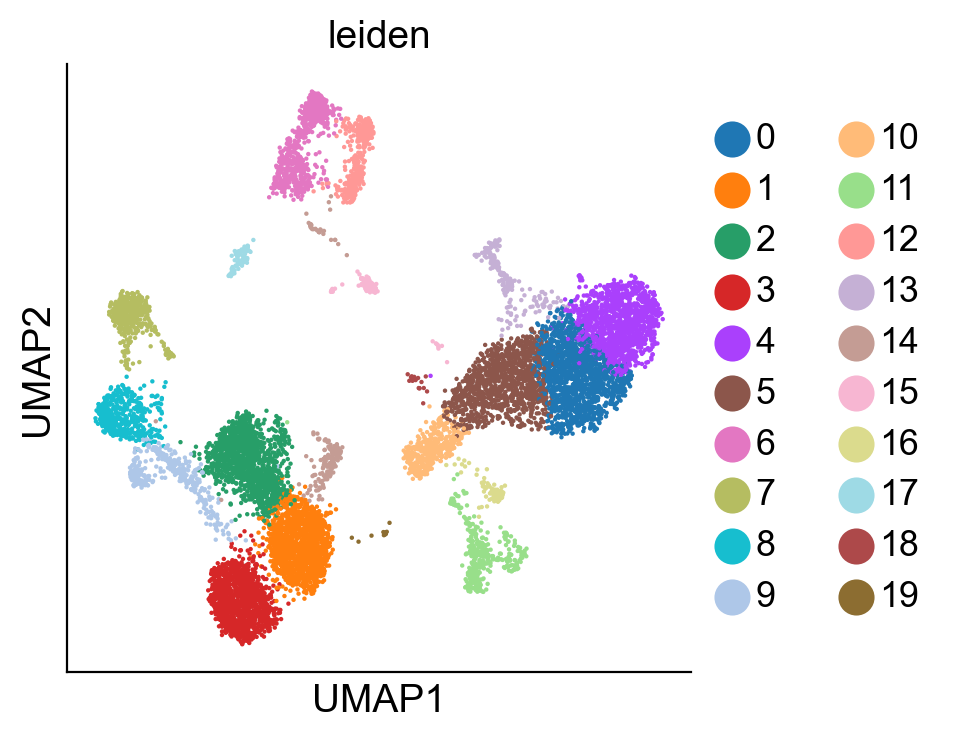

In [4]:
sc.pl.umap(pbmc, color=['leiden'])

# Different usecases

## How to pick cutoffs

Determining how to select the correct $\phi'$ and $p$-value cutoffs for a particular dataset depends on many aspects of the dataset, some of which are not knowable. To select the number of features, we first calculate two of the knowable statistics on which correct feature selection will depend: the number of cells and the median sequencing depth. If there are insufficient numbers of cells (less than 150, say) or the dataset is shallowly sequenced (for example, less than 3000 UMI/cell), then feature selection becomes very difficult. In these cases, we suggest selecting the top 10% of $\phi'$ that are significant, and carefully studying the results for biological meaning. If, on the other hand, the dataset has sufficient numbers of cells and sequencing depth, we then calculate the percent of $\phi'$ that are significant, which is an approximation of the homogeneity of the dataset. If there are more than 5% of $\phi'$ that are significant (i.e. the dataset can be considered to be heterogenous), we suggest selecting the top 10% of $\phi'$ that are significant, and if not, we suggest selecting the top 1%. Note that the function will suggest cutoffs if the verbose parameter is set to 2 (see verbosity section in Advanced usage).

## Preparation of this section

There are many analysis steps for this section, so we will put all these steps in this section, which can safely be skipped without loss of understanding of the results. 

#### CD8+ T cell subsetting

Notice that BigSur suggests a cutoff when verbose = 2.

In [5]:
cd8_t_cells = pbmc[pbmc.obs['Celltype'].isin(['CD8+ T Cells'])].copy()

sc.pp.filter_cells(cd8_t_cells, min_genes=400)
sc.pp.filter_genes(cd8_t_cells, min_cells=3)
mcfano_feature_selection(cd8_t_cells, layer='counts', min_mcfano_cutoff=0.99, verbose = 2)
sc.pp.pca(cd8_t_cells)
sc.pp.neighbors(cd8_t_cells)
sc.tl.umap(cd8_t_cells)
sc.tl.leiden(cd8_t_cells)

Using 0.05 for pvalue cutoff and 0.99 for mcfano quantile cutoff for highly variable genes.
Calculating corrected Fano factors.
Fitting cv.
Using a coefficient of variation of 0.15.
After fitting, cv = 0.15
Finished calculating corrected Fano factors for 15186 genes in 0.207115 seconds.
Calculating p-values.
Finished calculating p-values in 1.193653 seconds.
There are 1384 cells with a median sequencing depth of 6708.5 UMI/cell. Since 5% of mcFanos are significant, we suggest selecting the top 1% of mcFanos that have p-values lower than 0.05. To do so, set min_mcfano_cutoff = 0.99.
Setting 92 genes as highly variable.
Top 92 selected genes: 
 ['AC011498.1' 'AC092903.2' 'AC107027.3' 'AC246817.2' 'ACTB' 'ACTG1'
 'AL160314.2' 'AL590705.1' 'AL603756.1' 'ANXA1' 'BCL11A' 'CACNB4'
 'CCDC168' 'CCL5' 'CDK6' 'CRIP1' 'CST7' 'CXXC5' 'CYB5D2' 'FAM30A' 'FTL'
 'GOLGA4' 'GTSCR1' 'GZMA' 'GZMK' 'H1FX' 'HOPX' 'ID2' 'IFI27' 'IFI44L'
 'IGHM' 'IGKC' 'IL7R' 'IRF1' 'ITGB1' 'ITPK1-AS1' 'JUN' 'JUNB' 'KCNMB2-AS1

#### Calculate UMAPs for the 10k PBMC dataset and the CD8+ T cell dataset, without reassigning the clusters

In [6]:
def calculate_umap_using_different_cutoffs(adata, mcfano_cutoff):
    '''This function selects features using different mcFano cutoffs and recalculates the UMAPs.'''
    params_dict = {'min_mcfano_cutoff':mcfano_cutoff}

    adata_copy = adata.copy()

    mcfano_feature_selection(adata_copy, layer='counts', **params_dict) 
    sc.pp.pca(adata_copy)
    sc.pp.neighbors(adata_copy)
    sc.tl.umap(adata_copy)

    return adata_copy

In [7]:
adata_dict_pbmc = {}
adata_dict_cd8 = {}

for mcfano_cutoff in [0.9, 0.99]:
    adata_dict_pbmc[f'mcfano quantile cutoff = {mcfano_cutoff}'] = calculate_umap_using_different_cutoffs(pbmc, mcfano_cutoff)
    adata_dict_cd8[f'mcfano quantile cutoff = {mcfano_cutoff}'] = calculate_umap_using_different_cutoffs(cd8_t_cells, mcfano_cutoff)
        

Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.55
Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.15
Using 0.05 for pvalue cutoff and 0.99 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.55
Using 0.05 for pvalue cutoff and 0.99 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.15


#### Calculating of the enrichment of T cell marker for the PBMC dataset, and the memory CD8+ T cell marker for the CD8+ T cell dataset

In [8]:
def calculate_enrichment(adata, gene, starting_seed = 0):
    '''This function assigns clusters (using the starting seed) and calculates the enrichment of the specified gene for each cluster.'''
    adata_copy = adata.copy()

    sc.tl.leiden(adata_copy, random_state=starting_seed)

    df = sc.get.obs_df(adata_copy, keys = [gene, 'leiden'])

    df_enrichment_temp = df.groupby('leiden', observed=False).mean() / df[gene].mean()

    df_enrichment_temp['mcfano quantile cutoff'] = f'{mcfano_cutoff}'

    df_enrichment_temp['Random seed'] = starting_seed

    return df_enrichment_temp

In [9]:
gene = 'CD3E'
df_enrichment_pbmc = pd.DataFrame()

for mcfano_cutoff in [0.9, 0.99]:
    adata = adata_dict_cd8[f'mcfano quantile cutoff = {mcfano_cutoff}']
    df_temp = calculate_enrichment(adata, gene, starting_seed = 0)
    df_enrichment_pbmc = pd.concat([df_enrichment_pbmc, df_temp])

In [10]:
gene = 'CCL5'
rng = np.random.default_rng()
df_enrichment_cd8 = pd.DataFrame()

for mcfano_cutoff in [0.9, 0.99]:
    adata = adata_dict_cd8[f'mcfano quantile cutoff = {mcfano_cutoff}']
    df_temp = calculate_enrichment(adata, gene, starting_seed = 0)
    df_enrichment_cd8 = pd.concat([df_enrichment_cd8, df_temp[df_temp['CCL5'].max() == df_temp['CCL5']]])

    for iteration in range(40):
        seed = rng.choice(adata.shape[0])
        df_temp = calculate_enrichment(adata, gene, starting_seed = seed)
        df_enrichment_cd8 = pd.concat([df_enrichment_cd8, df_temp[df_temp['CCL5'].max() == df_temp['CCL5']]])

## Usecase where cutoffs don't particularly matter

A good example of a case where the number of selected genes (and the algorithm used to select features) has little effect on the result is the full 10k PBMC dataset. Here, we will select the top 10% of $\phi'$ that are significant and the top 1% $\phi'$ that are significant. We will then compare the UMAPs that result from selecting different features by calculating PCA, neighbors, and UMAP, without reassigning the clusters. 

Text(0.6, 1.2, 'mcFano quantile cutoff')

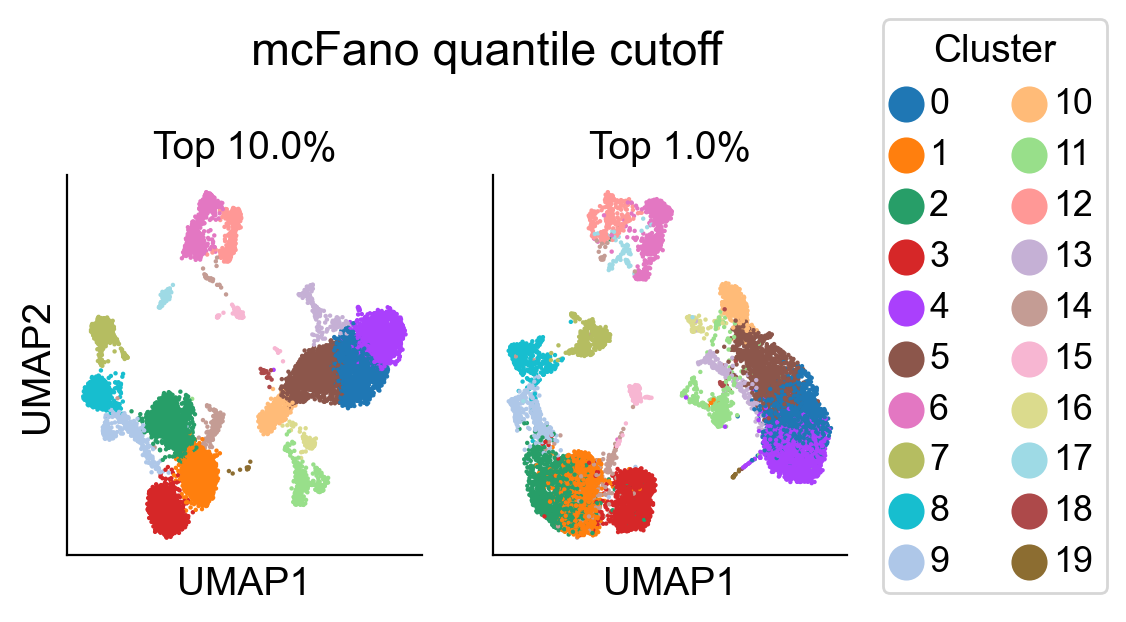

In [48]:
fig, axes = plt.subplots(1,2, figsize = (5, 2.5))

for col, mcfano_cutoff in enumerate([0.9, 0.99]):
    # prep plot
    ax = axes[col]
    adata_copy = adata_dict_pbmc[f'mcfano quantile cutoff = {mcfano_cutoff}']
    
    # plot umap
    sc.pl.umap(adata_copy, color = 'leiden', ax = ax, show = False)
    
    # Plot fixes

    ## x axis

    ## y axis
    if col != 0:
        ax.set_ylabel('')

    ## Title
    ax.set_title(f'Top {np.round((1 - mcfano_cutoff)*100, 1)}%')

    ## Legend
    if (col == 1):
        ax.legend(loc = (1.1, -0.1), ncol = 2, title = 'Cluster')

    else:
        ax.legend().remove()

# Suptitle
fig.suptitle('mcFano quantile cutoff', y = 1.2, x = 0.6)

The clusters are less separated if the $\phi'$ cutoff is set too high, but they are still distinguishable, and the groups of cells that consist of multiple clusters (i.e., the "cell types") are still well separated. 

### Quantification of the effect changing the number of genes has on the ability to cluster T cells

In the paper, we defined an "enrichment score" which is the fold change in the average expression of each cluster of a gene to the average expression of that gene in all cells. We can use this score to quantify the effect changing the number of genes has on the ability to cluster the T cells together. 

Text(0, 0.5, 'Enrichment of CD3E')

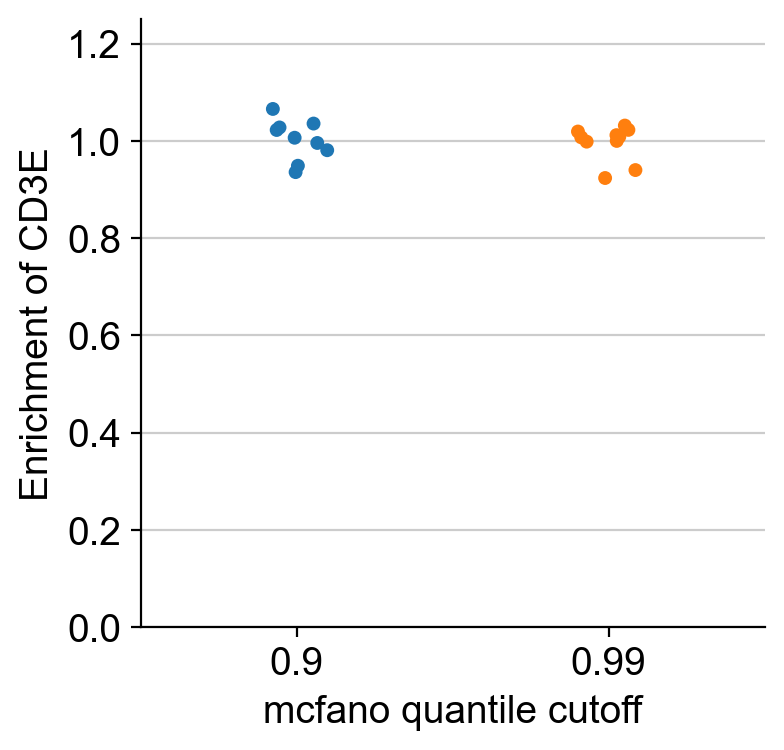

In [41]:
# Prep plot
fig, ax = plt.subplots()
color_palette = {cutoff:color for cutoff, color in zip(df_enrichment_pbmc['mcfano quantile cutoff'].unique(), sns.color_palette()[:4])}

sns.stripplot(data = df_enrichment_pbmc, x = 'mcfano quantile cutoff', y = 'CD3E', hue = 'mcfano quantile cutoff', ax = ax, palette = color_palette)

ax.set_ylim([0, 1.25])
ax.set_ylabel('Enrichment of CD3E')

The enrichment of the clusters differ a little, but overall are quite similar.

## Usecase where feature selection _will_ influence the result

To show the impact feature selection can have when trying to separate similar groups of cells, we will identify and subset the memory CD8+ T cells.

### Subsetting of memory CD8+ T cells

Here, we set the mcfano quantile cutoff to 0.99 (i.e., we select the top 1% of significant $\phi$), as suggested by the algorithm (see verbosity in the Advanced Usage section).

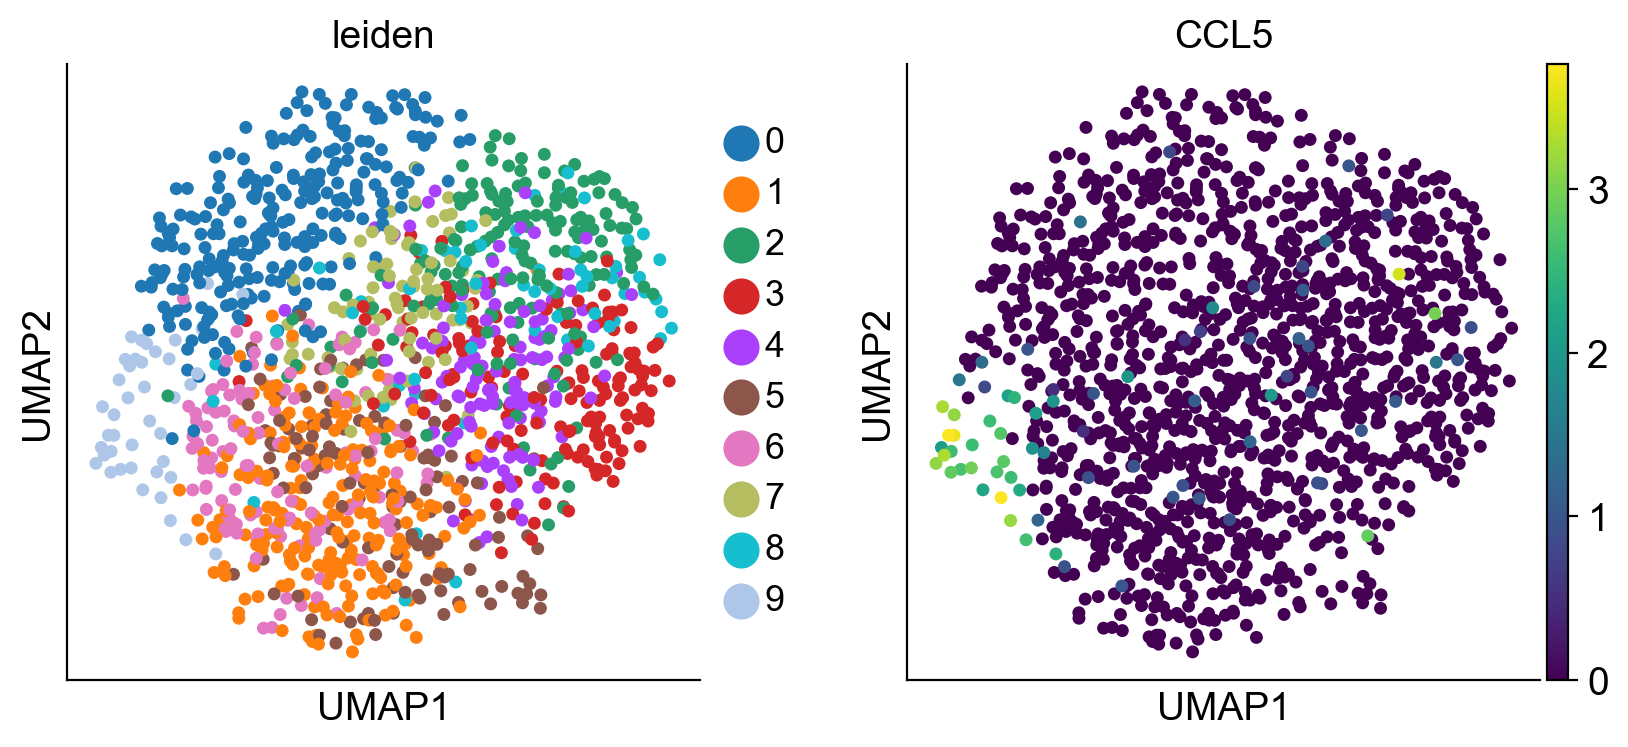

In [13]:
sc.pl.umap(cd8_t_cells, color = ['leiden', 'CCL5'])

We can observe that most of the cells expressing CCL5 are assigned to a single cluster, cluster 9. 

### Changing number of selected features

To quantify the effect of changing the number of features, we can calculate the enrichment of CCL5 of each cluster (as in the example above).

/var/folders/rk/963s32ts3r7clhq0w3ccryjr0000gn/T/ipykernel_15255/1730945160.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()
/var/folders/rk/963s32ts3r7clhq0w3ccryjr0000gn/T/ipykernel_15255/1730945160.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


Text(0.05, 0.5, 'mcFano quantile cutoff')

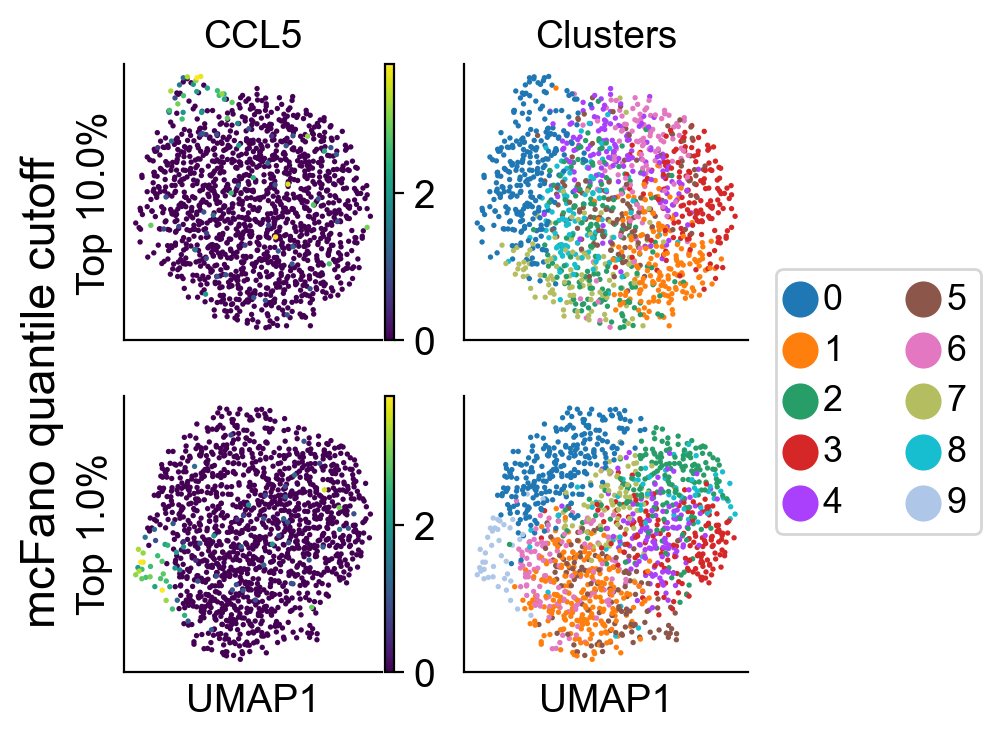

In [52]:
fig, axes = plt.subplots(2,2)

for row, mcfano_cutoff in enumerate([0.9, 0.99]):
    
    adata_copy = adata_dict_cd8[f'mcfano quantile cutoff = {mcfano_cutoff}'].copy()

    sc.tl.leiden(adata_copy, key_added='test')

    for col, color in enumerate(['CCL5', 'test']):
        # prep plot
        ax = axes[row, col]
        # plot umap
        sc.pl.umap(adata_copy, color = color, ax = ax, show = False, s = 15)

        # Plot fixes
        ## x axis
        if row != 1:
            ax.set_xlabel('')

        ## y axis
        if col != 0:
            ax.set_ylabel('')
        else:
            ax.set_ylabel(f'Top {(1-mcfano_cutoff)*100:.1f}%')

        ## Title
        if (row == 0):
            if (col == 0):
                ax.set_title(f'CCL5')
            else:
                ax.set_title(f'Clusters')

        else:
            ax.set_title('')


        ## Legend
        if (row == 1) and (col == 1):
            ax.legend(loc = (1.1, 0.5), ncol = 2, title = '')

        else:
            ax.legend().remove()

fig.supylabel('mcFano quantile cutoff', x = 0.05, y = 0.5)

We can see that the CCL5+ cluster found when selecting only the top 1% of $\phi'$ that are significant is no longer present when using the top 10% of $\phi'$ that are significant. However, they seem to still be grouping together on the UMAP, implying that a change of parameters, such as a different starting seed, could have resulted in these cells being assigned with specificity to one cluster. We assessed the effect the choice of random seed had on enrichment below. For each set of selected features, 40 different starting seeds of the Leiden algorithm were selected and clusters were subsequently assigned. 

The plot below shows the maximum enrichment from each set of clusters. 

Text(0, 0.5, 'Max enrichment of clusters \n per random seed')

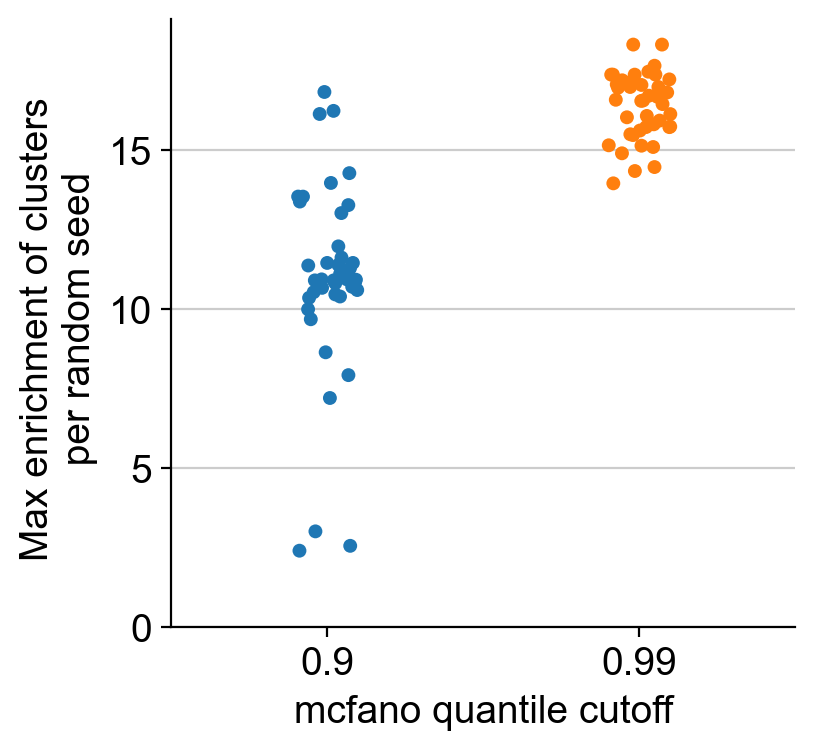

In [15]:
# Prep plot
fig, ax = plt.subplots()
color_palette = {cutoff:color for cutoff, color in zip(df_enrichment_cd8['mcfano quantile cutoff'].unique(), sns.color_palette()[:4])}

sns.stripplot(data = df_enrichment_cd8, x = 'mcfano quantile cutoff', y = 'CCL5', hue = 'mcfano quantile cutoff', ax = ax, palette = color_palette)

ax.set_ylim([0, None])

ax.set_ylabel('Max enrichment of clusters \n per random seed')

We can see that the maximum enrichment when using a quantile cutoff of 0.99 is on average greater than when using a quantile cutoff of 0.9; in addition, we can see that the enrichments are less sensitive to choice of random seed when selecting fewer genes. 

# Troubleshooting

Reimport adata for demonstration

In [16]:
pbmc = sc.read_10x_h5('10k_PBMC_3p_nextgem_Chromium_X_raw_feature_bc_matrix.h5') # read in adata
pbmc.var_names_make_unique()
pbmc.layers['counts'] = pbmc.X.copy()

/Users/emmanueldollinger/.local/share/mamba/envs/bigsur_testing/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/emmanueldollinger/.local/share/mamba/envs/bigsur_testing/lib/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Default usage: specify adata and layer of counts

We require filtering genes before usage:

In [17]:
try:
    mcfano_feature_selection(pbmc, layer='counts')
except Exception as err:
    print(f'Exception: {err}')


Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
Exception: Zero gene means were found, remove genes with no counts before calculating mcFanos.


In [18]:
sc.pp.filter_cells(pbmc, min_genes=400)
sc.pp.filter_genes(pbmc, min_cells=3)

In [19]:
pbmc.shape

(11893, 22300)

In [20]:
sc.pp.normalize_total(pbmc, target_sum=1e4)
sc.pp.log1p(pbmc)

We require passing counts, not normalized data:

In [21]:
try:
    mcfano_feature_selection(pbmc, layer='X')
except Exception as err:
    print(f'Exception: {err}')

Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
Exception: This function takes raw counts, normalized data was passed.


Default scanpy pipeline:

In [22]:
sc.pp.highly_variable_genes(pbmc)
sc.pp.pca(pbmc)
sc.pp.neighbors(pbmc)
sc.tl.umap(pbmc)
sc.tl.leiden(pbmc)

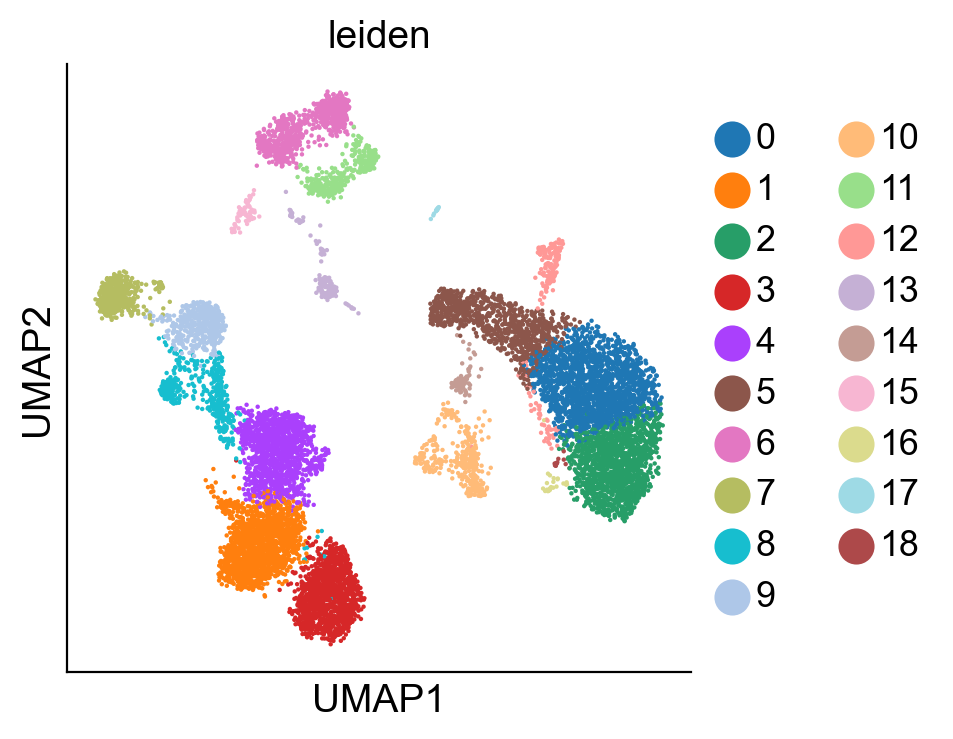

In [23]:
sc.pl.umap(pbmc, color='leiden')

Default mcFano usage:

In [24]:
mcfano_feature_selection(pbmc, layer='counts') # Replace sc.pp.highly_variable_genes(adata) call
sc.pp.pca(pbmc)
sc.pp.neighbors(pbmc)
sc.tl.umap(pbmc)
sc.tl.leiden(pbmc)

Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.55


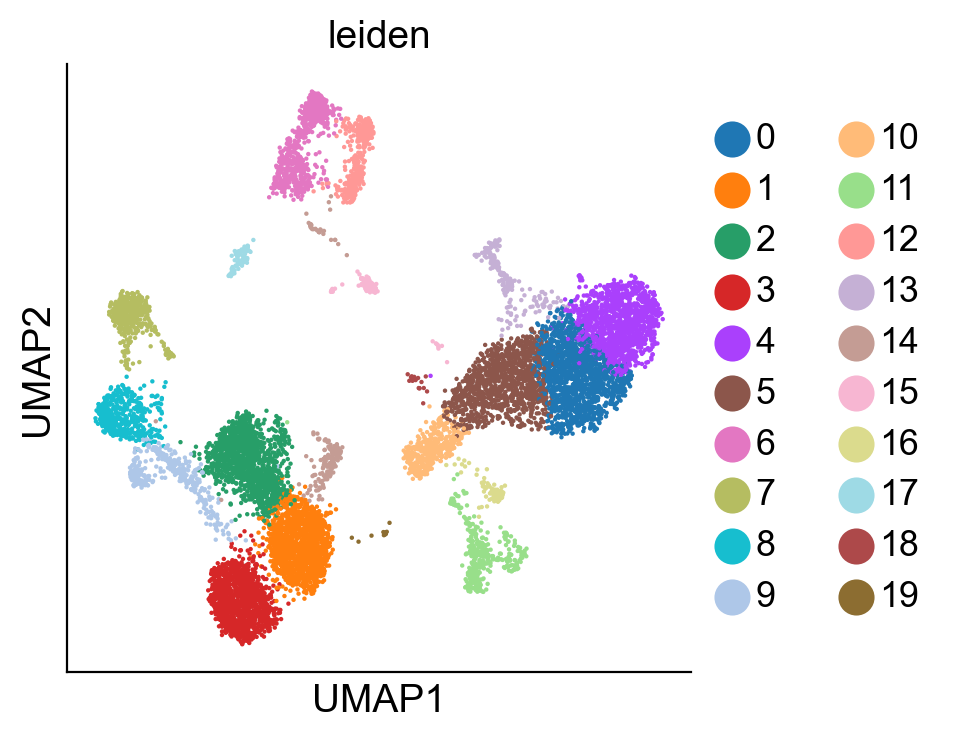

In [25]:
sc.pl.umap(pbmc, color='leiden')

# Advanced usage

### Tool has 3 verbosity levels: none, a little and a lot

In [26]:
mcfano_feature_selection(pbmc, layer='counts', verbose=0)

In [27]:
mcfano_feature_selection(pbmc, layer='counts', verbose=1)

Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.55


In [28]:
mcfano_feature_selection(pbmc, layer='counts', verbose=2)

Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
Calculating corrected Fano factors.
Fitting cv.
Using a coefficient of variation of 0.55.
After fitting, cv = 0.55
Finished calculating corrected Fano factors for 22300 genes in 4.446058 seconds.
Calculating p-values.
Finished calculating p-values in 5.619308 seconds.
There are 11893 cells with a median sequencing depth of 6927.0 UMI/cell. Since 25% of mcFanos are significant, we suggest selecting the top 10% of mcFanos that have p-values lower than 0.05. To do so, set min_mcfano_cutoff = 0.9.
Setting 1631 genes as highly variable.
Top 100 selected genes: 
 ['AC147651.1' 'ACRBP' 'C1QB' 'C2orf88' 'CAVIN2' 'CCL4' 'CCL5' 'CCL8'
 'CD79A' 'CDKN1C' 'CLDN5' 'CLEC1B' 'CLIC3' 'CLU' 'CMTM5' 'CST7' 'CTTN'
 'CXCL10' 'CXCL9' 'DNTT' 'FCGR3A' 'FGFBP2' 'GNG11' 'GNLY' 'GP1BB' 'GP9'
 'GZMA' 'GZMB' 'GZMH' 'GZMK' 'HBA1' 'HBA2' 'HBG2' 'HGD' 'HIST1H2AC'
 'HIST1H3H' 'HOPX' 'IFI27' 'IGHA1' 'IGHD' 'IGHG1' 'IGHG2' 'IGHG3'

Notice that with a verbosity of 2, we also suggest cutoffs to use for this dataset. See [How to pick cutoffs](#How-to-pick-cutoffs) within the "Advanced usage" section.

### User can pick whether to limit the number of genes called as highly variable:

In [29]:
mcfano_feature_selection(pbmc, layer='counts', verbose=1, n_genes_for_PCA=400)

Using 400 top genes and 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.55


In [30]:
pbmc.var['highly_variable'].sum()

np.int64(400)

Note that by default if there is a conflict between the cutoffs and the number of genes requested by the user, the cutoffs win:

In [31]:
mcfano_feature_selection(pbmc, layer='counts', verbose=1, n_genes_for_PCA=10000)

Using 10000 top genes and 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.55


/Users/emmanueldollinger/Documents/Projects/BigSur/BigSur/feature_selection.py:211: UserWarning: Number of genes meeting cutoffs (1631) is lower than user requested genes (10000). Only including genes meeting cutoff in "highly_variable" slot. Please increase the min_mcfano_cutoff, decrease the p_val_cutoff, or set either or both to False.
  warnings.warn(


In [32]:
pbmc.var['highly_variable'].sum()

np.int64(1631)

The p value cutoff can be disabled:

In [33]:
mcfano_feature_selection(pbmc, layer='counts', verbose=1, p_val_cutoff=None)

Using 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.55


We do NOT recommend turning off the p value criterion; however if considering different celltypes, p value cutoff isn't necessary (and can be faster computationally): 

In [34]:
mcfano_feature_selection(pbmc, layer='counts', verbose=2)
sc.pp.pca(pbmc)
sc.pp.neighbors(pbmc)
sc.tl.umap(pbmc)
sc.tl.leiden(pbmc)

Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
Calculating corrected Fano factors.
Fitting cv.
Using a coefficient of variation of 0.55.
After fitting, cv = 0.55
Finished calculating corrected Fano factors for 22300 genes in 4.453912 seconds.
Calculating p-values.
Finished calculating p-values in 5.701607 seconds.
There are 11893 cells with a median sequencing depth of 6927.0 UMI/cell. Since 25% of mcFanos are significant, we suggest selecting the top 10% of mcFanos that have p-values lower than 0.05. To do so, set min_mcfano_cutoff = 0.9.
Setting 1631 genes as highly variable.
Top 100 selected genes: 
 ['AC147651.1' 'ACRBP' 'C1QB' 'C2orf88' 'CAVIN2' 'CCL4' 'CCL5' 'CCL8'
 'CD79A' 'CDKN1C' 'CLDN5' 'CLEC1B' 'CLIC3' 'CLU' 'CMTM5' 'CST7' 'CTTN'
 'CXCL10' 'CXCL9' 'DNTT' 'FCGR3A' 'FGFBP2' 'GNG11' 'GNLY' 'GP1BB' 'GP9'
 'GZMA' 'GZMB' 'GZMH' 'GZMK' 'HBA1' 'HBA2' 'HBG2' 'HGD' 'HIST1H2AC'
 'HIST1H3H' 'HOPX' 'IFI27' 'IGHA1' 'IGHD' 'IGHG1' 'IGHG2' 'IGHG3'

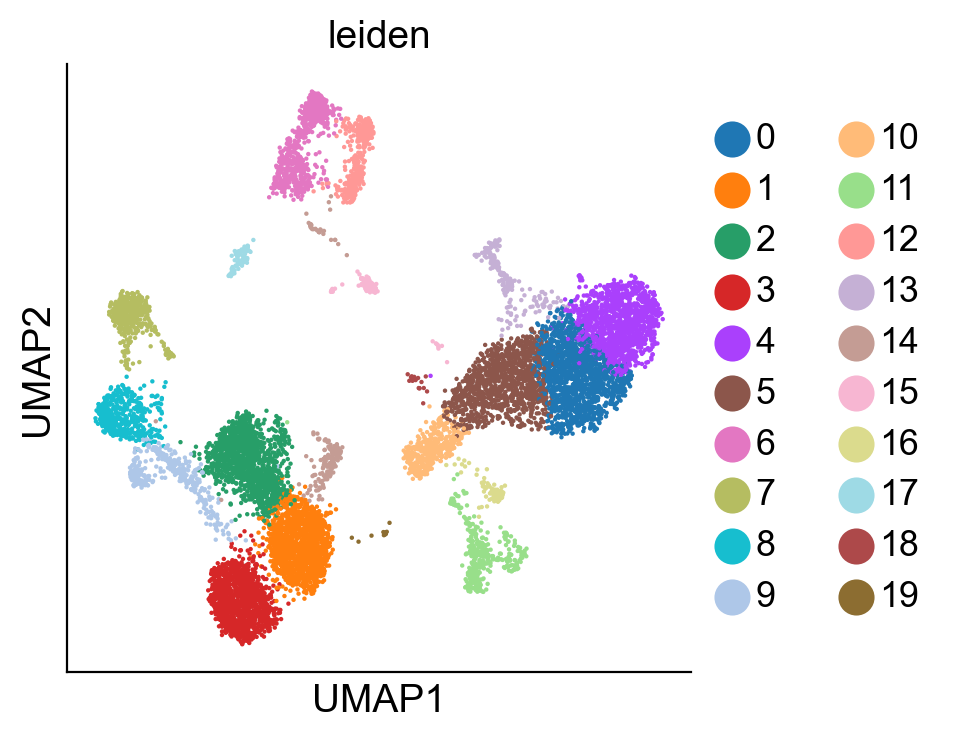

In [35]:
sc.pl.umap(pbmc, color='leiden')

In [36]:
mcfano_feature_selection(pbmc, layer='counts', p_val_cutoff=None, verbose=2)
sc.pp.pca(pbmc)
sc.pp.neighbors(pbmc)
sc.tl.umap(pbmc)
#sc.tl.leiden(adata) not recalculate leiden to show difference

Using 0.9 for mcfano quantile cutoff for highly variable genes.
Calculating corrected Fano factors.
Fitting cv.
Using a coefficient of variation of 0.55.
After fitting, cv = 0.55
Finished calculating corrected Fano factors for 22300 genes in 4.484481 seconds.
Skipping p-value calculation.
There are 11893 cells with a median sequencing depth of 6927.0 UMI/cell. Since 25% of mcFanos are significant, we suggest selecting the top 10% of mcFanos that have p-values lower than 0.05. To do so, set min_mcfano_cutoff = 0.9.
Setting 2230 genes as highly variable.
Top 100 selected genes: 
 ['AC147651.1' 'ACRBP' 'C1QB' 'C2orf88' 'CAVIN2' 'CCL4' 'CCL5' 'CCL8'
 'CD79A' 'CDKN1C' 'CLDN5' 'CLEC1B' 'CLIC3' 'CLU' 'CMTM5' 'CST7' 'CTTN'
 'CXCL10' 'CXCL9' 'DNTT' 'FCGR3A' 'FGFBP2' 'GNG11' 'GNLY' 'GP1BB' 'GP9'
 'GZMA' 'GZMB' 'GZMH' 'GZMK' 'HBA1' 'HBA2' 'HBG2' 'HGD' 'HIST1H2AC'
 'HIST1H3H' 'HOPX' 'IFI27' 'IGHA1' 'IGHD' 'IGHG1' 'IGHG2' 'IGHG3' 'IGHG4'
 'IGHM' 'IGHV3-15' 'IGKC' 'IGKV1-39' 'IGKV1-9' 'IGKV4-1' 'IGL

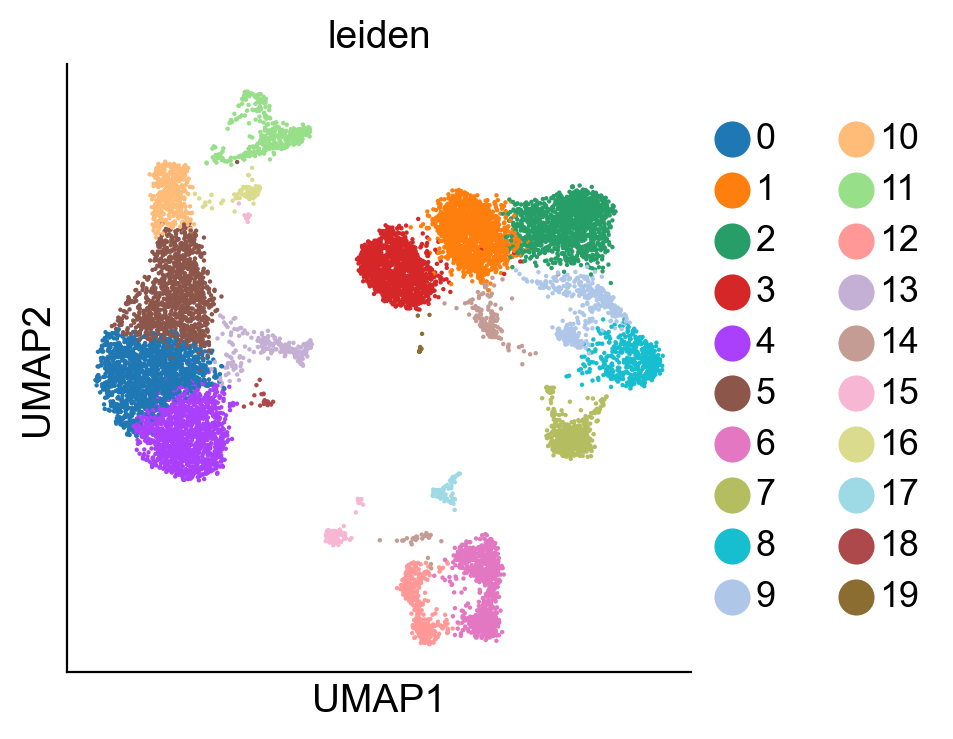

In [37]:
sc.pl.umap(pbmc, color='leiden')

UMAPs are similar

### Fitting coefficient of variation

CV is the only fitted parameter in our model. We provide a way to fit CV, which is done by default.

Note that fitting CV is only necessary if the dataset being considered is cells that are similar (i.e. intra celltype analysis). Fitting CV for inter celltype analysis will take very long and possibly won't work (function is designed to throw an error). In these cases, we suggest fixing cv = 0.5.

In [38]:
mcfano_feature_selection(cd8_t_cells, layer='counts', cv=None) # Fit CV

Using 0.05 for pvalue cutoff and 0.9 for mcfano quantile cutoff for highly variable genes.
After fitting, cv = 0.15


In [39]:
?mcfano_feature_selection

Signature:
mcfano_feature_selection(
    adata: anndata._core.anndata.AnnData,
    layer: str,
    cv: Union[bool, float] = None,
    n_genes_for_PCA: Union[bool, int] = False,
    min_mcfano_cutoff: Union[bool, float] = 0.9,
    p_val_cutoff: Union[bool, float] = 0.05,
    return_residuals: bool = False,
    n_jobs: int = -2,
    verbose: int = 1,
)
Docstring:
Calculate the corrected Fano factor for all genes in the dataset. mc_Fano column will be added to .var. Highly_variable column will be added to .var based on the n_genes_for_pca, min_mcfano_cutoff and p_val_cutoff parameters.

Parameters
----------
adata - adata object containing information about the raw counts and gene names.
layer - String, describing the layer of adata object containing raw counts (pass "X" if raw counts are in adata.X).
cv - Float, coefficient of variation for the given dataset. If None, the CV will be estimated.
n_genes_for_PCA - [Int, Bool], top number of genes to use for highly_variable slot, ranked by c

Package list:

In [40]:
!cat environment.yml

name: bigsur
channels:
  - conda-forge
dependencies:
  - _r-mutex=1.0.1=anacondar_1
  - anndata=0.11.4=pyhd8ed1ab_0
  - appnope=0.1.4=pyhd8ed1ab_1
  - arpack=3.9.1=nompi_h1f29f7c_102
  - array-api-compat=1.12.0=pyhe01879c_0
  - asttokens=3.0.0=pyhd8ed1ab_1
  - brotli=1.1.0=h5505292_3
  - brotli-bin=1.1.0=h5505292_3
  - bwidget=1.10.1=hce30654_1
  - bzip2=1.0.8=h99b78c6_7
  - c-ares=1.34.5=h5505292_0
  - ca-certificates=2025.6.15=hbd8a1cb_0
  - cached-property=1.5.2=hd8ed1ab_1
  - cached_property=1.5.2=pyha770c72_1
  - cairo=1.18.4=h6a3b0d2_0
  - cctools_osx-arm64=1010.6=h729f01a_6
  - clang=20.1.7=default_hcdeef69_0
  - clang-20=20.1.7=default_h03658f6_0
  - clang_impl_osx-arm64=20.1.7=h5bfba70_25
  - clang_osx-arm64=20.1.7=h07b0088_25
  - clangxx=20.1.7=default_haca757a_0
  - clangxx_impl_osx-arm64=20.1.7=h12301e7_25
  - clangxx_osx-arm64=20.1.7=h07b0088_25
  - colorama=0.4.6=pyhd8ed1ab_1
  - comm=0.2.2=pyhd8ed1ab_1
  - compiler-rt=20.1.7=hd2aecb6_0
  - compiler-rt_osx-arm64=20.1.7=h7